In [117]:
import os
import shutil
import glob
from PIL import Image

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import splitfolders

import tensorflow as tf

tf.__version__

'2.5.0'

# Preprocess data

## Split data

In [3]:
should_prepare_data = False

train_sequential = True

train_residual = True

In [4]:
def prepare_data():
    
    dirpaths = []
    class_names = []
    
    # generate list with roots for folders
    for dirpath, folder, _ in os.walk('./data/flowers/'):
        dirpaths.append(dirpath)
        class_names.append(folder)
    
    class_names = class_names[0]
        
    j = 0
    
    # loop through roots of image folders
    for dirpath in dirpaths[1:]:

        dst_dir = './data/input_flowers'

        if not os.path.exists(dst_dir):
            os.mkdir(dst_dir)

        i = 1  # no. of image

        for jpg_file in glob.iglob(os.path.join(dirpath, '*.jpg')):

            img_path = os.path.join(dst_dir, class_names[j])

            if not os.path.exists(img_path):
                os.mkdir(img_path)

            new_name = f'{class_names[j]}/{j}_{i}.jpg'

            shutil.copy(jpg_file, os.path.join(dst_dir, new_name))

            i += 1

        j += 1

    # split images to train/val/test folders
    splitfolders.ratio('./data/input_flowers', output='./data/output_flowers', seed=1337, ratio=(.7, .15, .15))
    
    return class_names

In [181]:
if should_prepare_data:
    prepare_data()

## Count images of each class and display chart

In [182]:
def get_count_of_images(split_folders):
    
    '''
    Counts number of files in every class in train/validation/test sets.
    
    Arguments:
    split_folders --- path to train/val/test which must contain folders of each class
                      e.g. './data/train'
    '''
    
    dict_count = {}
     
    for dir_path in split_folders:
    
        dir_name = os.path.basename(os.path.normpath(dir_path))
        dict_count[dir_name] = {}
    
        for root, dirs, files in os.walk(dir_path):

            if len(files) > 0:

                class_name = os.path.basename(os.path.normpath(root))
                count = len(files)

                dict_count[dir_name][class_name] = count
                
    return dict_count

In [183]:
split_folders = ['./data/output_flowers/train', './data/output_flowers/val', './data/output_flowers/test']

data = get_count_of_images(split_folders)

In [184]:
df = pd.DataFrame(data)
df['total']= df.sum(axis=1)
df

,train,val,test,total
tulip,688,147,149,984
rose,548,117,119,784
dandelion,736,157,159,1052
sunflower,513,109,111,733
daisy,534,114,116,764


In [185]:
def display_graph_of_images_count(dataframe):
    ax = dataframe.plot(kind='bar', figsize=(12, 8), title='Images count per class',
                        xlabel='Class', ylabel='Count', legend=False)

    for i in range(4):
        ax.bar_label(ax.containers[i], label_type='edge', rotation=90, fontsize=12, padding=3)

    ax.margins(y=0.1)
    ax.legend()

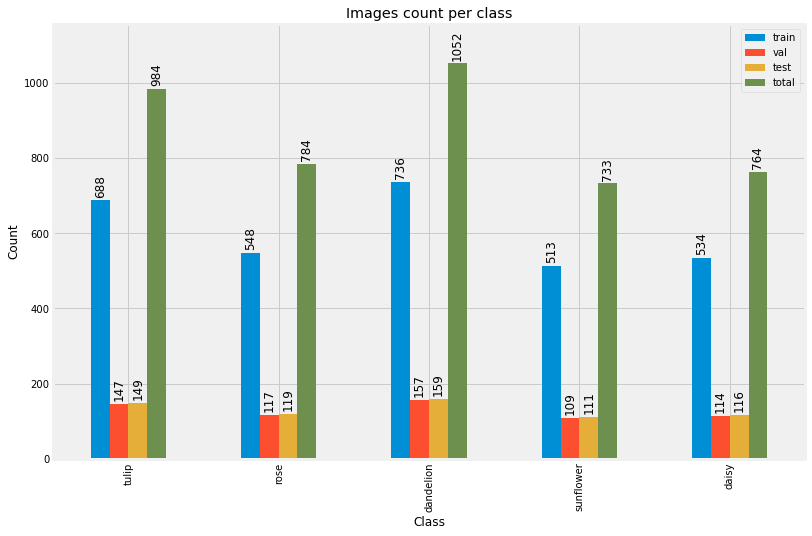

In [186]:
display_graph_of_images_count(df)

# Define train/val/test sets

In [5]:
batch_size = 32
img_height = 240
img_width = 240

train_dir = './data/output_flowers/train/'
val_dir = './data/output_flowers/val/'
test_dir = './data/output_flowers/test/'

In [6]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    label_mode='int',
    batch_size=batch_size,
    image_size=(img_height, img_width)
    )

Found 3019 files belonging to 5 classes.


In [7]:
validation_ds = tf.keras.preprocessing.image_dataset_from_directory(
    val_dir,
    label_mode='int',
    batch_size=batch_size,
    image_size=(img_height, img_width)
    )


Found 644 files belonging to 5 classes.


In [8]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    label_mode='int',
    batch_size=batch_size,
    image_size=(img_height, img_width)
    )


Found 654 files belonging to 5 classes.


In [9]:
class_names = train_ds.class_names
class_names

['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']

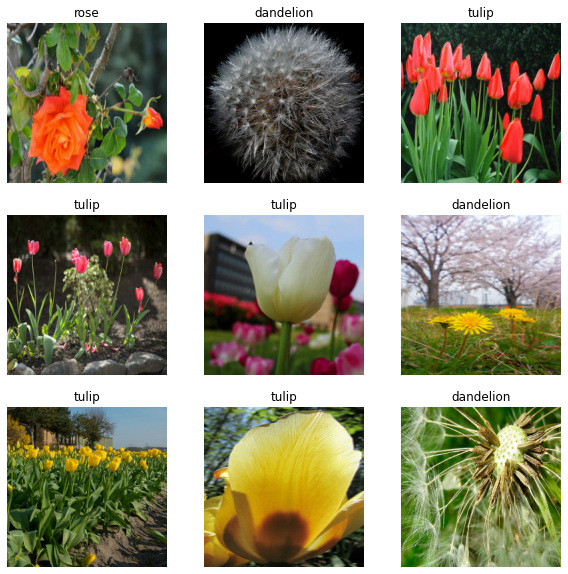

In [10]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")


# Data augmentation

In [50]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        rotation_range=10,
        shear_range=0.2,
        width_shift_range=0.2,
        height_shift_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True)

val_datagen = tf.keras.preprocessing.image.ImageDataGenerator()

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='sparse')

validation_generator = val_datagen.flow_from_directory(
        val_dir,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='sparse')

Found 3019 images belonging to 5 classes.
Found 644 images belonging to 5 classes.


# Deep learning model

In [51]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [84]:
def get_model(num_classes, dropout_rate=0.5):
    model = tf.keras.Sequential([

        tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
        
        layers.Conv2D(32, (3,3), padding='same'),
        layers.Activation('relu'),
        layers.MaxPooling2D(),

        layers.Conv2D(32, (3,3), padding='same'),
        layers.Activation('relu'),
        layers.MaxPooling2D(),
        
        layers.Conv2D(64, (3,3), padding='same'),
        layers.Activation('relu'),
        layers.MaxPooling2D(),      
        
        layers.Conv2D(128, (3,3), padding='same'),
        layers.Activation('relu'),
        layers.MaxPooling2D(),      
        
        layers.Conv2D(128, (3,3), padding='same'),
        layers.Activation('relu'),
        layers.MaxPooling2D(),          

        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.Dense(num_classes)  
    ])
    
    return model

In [85]:
model = get_model(5)
    
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_16 (Rescaling)     (None, 240, 240, 3)       0         
_________________________________________________________________
conv2d_126 (Conv2D)          (None, 240, 240, 32)      896       
_________________________________________________________________
activation_70 (Activation)   (None, 240, 240, 32)      0         
_________________________________________________________________
max_pooling2d_84 (MaxPooling (None, 120, 120, 32)      0         
_________________________________________________________________
conv2d_127 (Conv2D)          (None, 120, 120, 32)      9248      
_________________________________________________________________
activation_71 (Activation)   (None, 120, 120, 32)      0         
_________________________________________________________________
max_pooling2d_85 (MaxPooling (None, 60, 60, 32)      

In [86]:
# Callbacks

def best_val_acc_callback(filepath):
    
    checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_path,
        save_weights_only=True,
        monitor='val_accuracy',
        mode='max',
        save_best_only=True)
    
    return checkpoint_callback


In [87]:
epochs = 50

checkpoint_path = './saved_weights/flowers_sequential_model'

best_val_acc = best_val_acc_callback(checkpoint_path)

if train_sequential:
    
    history = model.fit(
        train_generator,
        validation_data=validation_generator,
        epochs=epochs,
        callbacks=[best_val_acc]
    )

Epoch 1/50
95/95 [==============================] - 31s 317ms/step - loss: 1.5141 - accuracy: 0.3445 - val_loss: 1.1732 - val_accuracy: 0.4814
Epoch 2/50
95/95 [==============================] - 30s 317ms/step - loss: 1.1879 - accuracy: 0.5045 - val_loss: 1.1969 - val_accuracy: 0.5186
Epoch 3/50
95/95 [==============================] - 30s 316ms/step - loss: 1.0933 - accuracy: 0.5614 - val_loss: 0.9905 - val_accuracy: 0.5870
Epoch 4/50
95/95 [==============================] - 30s 316ms/step - loss: 1.0202 - accuracy: 0.5999 - val_loss: 1.0562 - val_accuracy: 0.5730
Epoch 5/50
95/95 [==============================] - 30s 316ms/step - loss: 0.9877 - accuracy: 0.6171 - val_loss: 1.0404 - val_accuracy: 0.5807
Epoch 6/50
95/95 [==============================] - 30s 313ms/step - loss: 0.9152 - accuracy: 0.6459 - val_loss: 1.0307 - val_accuracy: 0.6382
Epoch 7/50
95/95 [==============================] - 30s 314ms/step - loss: 0.9106 - accuracy: 0.6558 - val_loss: 0.8085 - val_accuracy: 0.6801

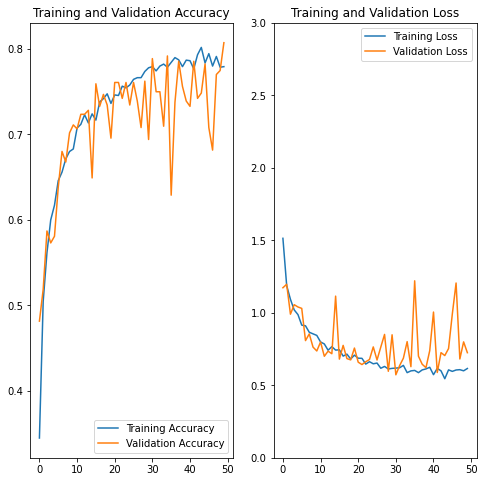

In [88]:
if train_sequential:
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.ylim((0, 3))
    plt.show()

In [90]:
model.load_weights('./saved_weights/flowers_sequential_model')

In [91]:
if train_sequential:
    model.evaluate(test_ds)

21/21 [==============================] - 0s 16ms/step - loss: 0.6444 - accuracy: 0.8012


## Residual model

In [70]:
def conv2d_block(input_tensor, n_filters):
    
    x = input_tensor
    
    x = layers.Conv2D(n_filters, (3,3), padding='same', activation='relu')(x)
    
    x = layers.Conv2D(n_filters, (3,3), padding='same', activation='relu')(x)
    
    x = layers.MaxPooling2D()(x)
    
    return x
    

In [71]:
def residual_block(input_tensor, n_filters):
    
    block_1 = conv2d_block(input_tensor, n_filters=n_filters)
    
    x = layers.Conv2D(n_filters, (3,3), padding='same', activation='relu')(block_1)
    
    x = layers.Conv2D(n_filters, (3,3), padding='same', activation='relu')(x)
    
    x = layers.add([block_1, x])
    
    return x

In [75]:
def get_res_model(num_classes, filters_conv2d_blocks):
    
    inputs = layers.Input(shape=(img_height, img_width, 3))
    
    x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)
    
    for num_filters in filters_conv2d_blocks:
        x = residual_block(input_tensor=x, n_filters=num_filters)
    
    x = layers.Flatten()(x)
    
    x = layers.Dense(512, activation='relu')(x)
    outputs = layers.Dense(num_classes)(x)
    
    model = tf.keras.Model(inputs=inputs, outputs=outputs, name="residual_model")
    
    return model

In [76]:
model_res = get_res_model(5, [32, 64, 64, 64, 128])
model_res.summary()

Model: "residual_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 240, 240, 3) 0                                            
__________________________________________________________________________________________________
rescaling_15 (Rescaling)        (None, 240, 240, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_106 (Conv2D)             (None, 240, 240, 32) 896         rescaling_15[0][0]               
__________________________________________________________________________________________________
conv2d_107 (Conv2D)             (None, 240, 240, 32) 9248        conv2d_106[0][0]                 
_____________________________________________________________________________________

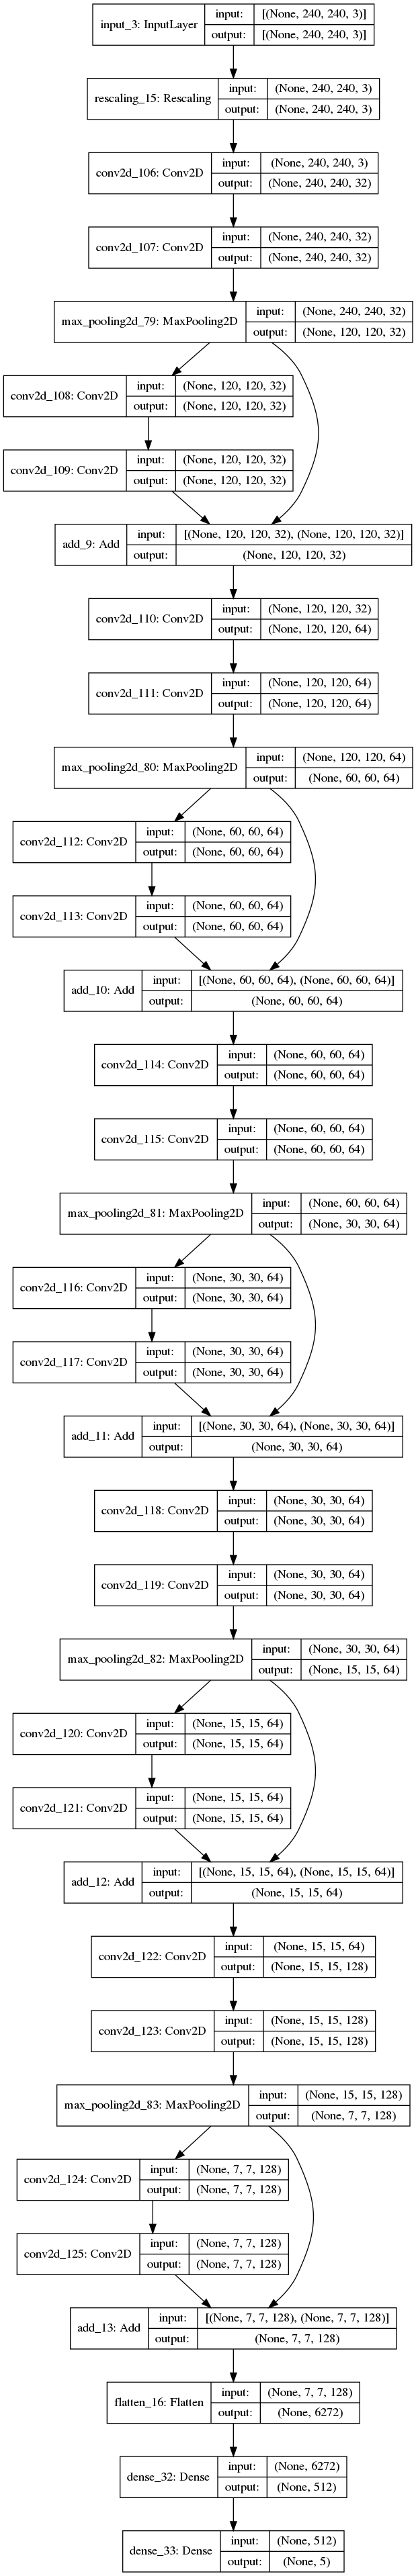

In [77]:
tf.keras.utils.plot_model(model_res, "res_model.png", show_shapes=True)


In [78]:
model_res.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0005),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [81]:
epochs = 50

checkpoint_path = './saved_weights/flowers_residual_model'

best_val_acc = best_val_acc_callback(checkpoint_path)

if train_residual:
    
    history_res = model_res.fit(
            train_generator,
            validation_data=validation_generator,
            epochs=epochs,
            callbacks=[best_val_acc]
    )

Epoch 1/50
95/95 [==============================] - 34s 328ms/step - loss: 1.5972 - accuracy: 0.2623 - val_loss: 1.6283 - val_accuracy: 0.2997
Epoch 2/50
95/95 [==============================] - 30s 319ms/step - loss: 1.2945 - accuracy: 0.4525 - val_loss: 1.0793 - val_accuracy: 0.5311
Epoch 3/50
95/95 [==============================] - 30s 317ms/step - loss: 1.2148 - accuracy: 0.5247 - val_loss: 1.1075 - val_accuracy: 0.5202
Epoch 4/50
95/95 [==============================] - 30s 319ms/step - loss: 1.1419 - accuracy: 0.5346 - val_loss: 1.0375 - val_accuracy: 0.6211
Epoch 5/50
95/95 [==============================] - 30s 319ms/step - loss: 1.0787 - accuracy: 0.5826 - val_loss: 1.0218 - val_accuracy: 0.6227
Epoch 6/50
95/95 [==============================] - 30s 316ms/step - loss: 1.0138 - accuracy: 0.6048 - val_loss: 0.9094 - val_accuracy: 0.6537
Epoch 7/50
95/95 [==============================] - 30s 315ms/step - loss: 0.9977 - accuracy: 0.6161 - val_loss: 0.9354 - val_accuracy: 0.6491

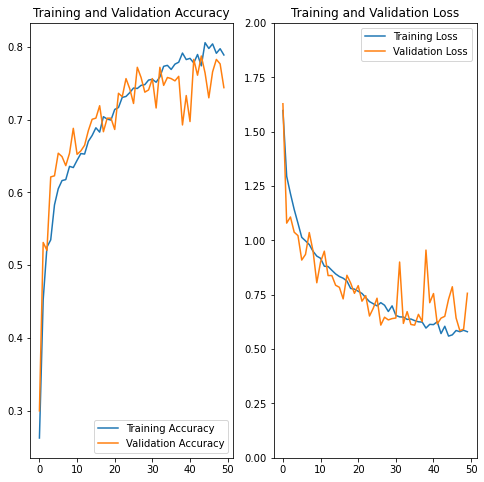

In [82]:
def display_plots(history_var):
    acc = history_var.history['accuracy']
    val_acc = history_var.history['val_accuracy']

    loss = history_var.history['loss']
    val_loss = history_var.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.ylim((0, 2))
    plt.show()
    
    
if train_residual:
    display_plots(history_res)

In [92]:
model_res.load_weights('./saved_weights/flowers_residual_model')

In [93]:
model_res.evaluate(test_ds)

21/21 [==============================] - 2s 64ms/step - loss: 0.7301 - accuracy: 0.7875


[0.7301135659217834, 0.7874617576599121]

In [ ]:
from sklearn.metrics import classification_report

In [ ]:
y_true = test_ds[1]
y_pred = model_res.predict(test_ds)